In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install necessary libraries
!pip install audiomentations
!pip install torchsummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: soxr
    Found existing installation: soxr 1.0.0
    Uninstalling soxr-1.0.0:
      Successfully uninstalled soxr-1.0.0


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
import os
import shutil
import pandas as pd
from tqdm.notebook import tqdm

# --- Config ---
# Source: Your Drive folder
SOURCE_DIR = "/content/drive/MyDrive/Voice project/unzipped_dataset/cv-corpus-23.0-2025-09-05/en/clips"

# Destination: Local Colab folder (Fast!)
DEST_DIR = "/content/clips"

# CSV with the list of files we actually need
BALANCED_CSV = "/content/drive/MyDrive/voice_project/final_balanced_list.csv"

# --- The Copy Logic ---
print(f"Preparing to copy specific files to {DEST_DIR}...")

# 1. Create local folder
os.makedirs(DEST_DIR, exist_ok=True)

# 2. Load the list of files
df = pd.read_csv(BALANCED_CSV)
files_to_copy = df['path'].tolist()

print(f"Found {len(files_to_copy)} files in our balanced dataset.")

# 3. Copy Loop
copied_count = 0
missing_count = 0

print("files are copying...")
for filename in tqdm(files_to_copy):
    src_path = os.path.join(SOURCE_DIR, filename)
    dst_path = os.path.join(DEST_DIR, filename)

    # Only copy if it doesn't exist locally yet
    if not os.path.exists(dst_path):
        try:
            shutil.copy(src_path, dst_path)
            copied_count += 1
        except FileNotFoundError:
            missing_count += 1
            print(f"Warning: Could not find {filename} in Drive!")

print(f"\n Done! Copied {copied_count} files to local disk.")
if missing_count > 0:
    print(f"{missing_count} files were missing.")

# 4. Verify Storage usage
!du -sh /content/clips

Preparing to copy specific files to /content/clips...
📋 Found 10236 files in our balanced dataset.
files are copying...


  0%|          | 0/10236 [00:00<?, ?it/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
PROJECT_PATH = "/content/drive/MyDrive/Voice project/"
CLIPS_PATH = os.path.join(PROJECT_PATH, "unzipped_dataset/cv-corpus-23.0-2025-09-05/en/clips")
TRAIN_LIST = "/content/drive/MyDrive/voice_project/train_list.csv"
VAL_LIST = "/content/drive/MyDrive/voice_project/val_list.csv"
STATS_PATH = "/content/drive/MyDrive/voice_project/scaling_stats"
MODEL_SAVE_PATH = "/content/drive/MyDrive/voice_project/First_model_building.pth"

In [ ]:
try:
    GLOBAL_MEAN = np.load(os.path.join(STATS_PATH, "global_mean.npy"))
    GLOBAL_STD = np.load(os.path.join(STATS_PATH, "global_std.npy"))
    print(f"Loaded Stats: Mean={GLOBAL_MEAN:.2f}, Std={GLOBAL_STD:.2f}")
except Exception as e:
    print(f"Error loading stats: {e}")
    print("Make sure you have run the scaling script from the previous steps!")

Loaded Stats: Mean=-59.25, Std=11.95


In [ ]:
SAMPLE_RATE = 22050
DURATION = 5
N_MELS = 128
FIXED_LENGTH = SAMPLE_RATE * DURATION

AGE_MAP = {'teens': 0, 'twenties': 1, 'thirties': 2, 'fourties': 3, 'fifties': 4, '60plus': 5}
GENDER_MAP = {'female': 0, 'male': 1}

In [ ]:
# Define the augmentation pipeline
# p=0.5 means there is a 50% chance each effect is applied
augmentations = Compose([
    # 1. Add background static (Noise)
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),

    # 2. Change the speed without changing pitch (Time Stretch)
    # 0.8 = slower, 1.25 = faster
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),

    # 3. Change the pitch without changing speed (Pitch Shift)
    # -4 to 4 semitones (makes voice deeper or higher)
    # CRITICAL for fixing age bias!
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),

    # 4. Shift the audio in time (start a bit later/earlier)
    Shift(min_shift=-0.5, max_shift=0.5, p=0.5),
])

print("Augmentation recipe configured.")

Augmentation recipe configured.


In [ ]:
class VoiceDataset(Dataset):
    def __init__(self, csv_file, clips_dir, mean, std, transform=None):
        self.data_list = pd.read_csv(csv_file)
        self.clips_dir = clips_dir
        self.mean = mean
        self.std = std
        self.transform = transform # The augmentation recipe

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        row = self.data_list.iloc[idx]
        file_path = os.path.join(self.clips_dir, row['path'])

        # 1. Load Audio (Raw Waveform)
        try:
            # We load with librosa (this might be the bottleneck, so we use efficient settings)
            audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

            # Pad or Truncate to exactly 5 seconds
            if len(audio) < FIXED_LENGTH:
                audio = np.pad(audio, (0, FIXED_LENGTH - len(audio)), 'constant')
            else:
                audio = audio[:FIXED_LENGTH]

            # 2. --- APPLY AUGMENTATION (The New Part) ---
            if self.transform:
                # Apply the effects defined in Cell 3
                audio = self.transform(samples=audio, sample_rate=SAMPLE_RATE)

            # 3. Convert to Mel Spectrogram
            spectrogram = librosa.feature.melspectrogram(
                y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=2048, hop_length=512
            )

            # 4. Log Scale (Decibels)
            log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

            # 5. Standardize (Scaling) using Global Stats
            # (X - Mean) / Std
            norm_spectrogram = (log_spectrogram - self.mean) / self.std

            # 6. Prepare for PyTorch
            # Add channel dim: (128, 216) -> (1, 128, 216)
            spec_tensor = torch.tensor(norm_spectrogram, dtype=torch.float32).unsqueeze(0)

            # Labels
            age_label = torch.tensor(AGE_MAP[row['age']], dtype=torch.long)
            gender_label = torch.tensor(GENDER_MAP[row['gender']], dtype=torch.long)

            return spec_tensor, age_label, gender_label

        except Exception as e:
            # Fallback for bad files (shouldn't happen with our clean list, but good practice)
            print(f"Error loading {file_path}: {e}")
            return torch.zeros((1, 128, 216)), torch.tensor(0), torch.tensor(0)

print("Dataset class defined.")

Dataset class defined.


In [ ]:
class VoiceCNN(nn.Module):
    def __init__(self, num_age_classes=6, num_gender_classes=2):
        super(VoiceCNN, self).__init__()

        # Body
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Neck
        self.flatten = nn.Flatten()
        self.fc_shared = nn.Linear(64 * 16 * 27, 128) # 27648 -> 128
        self.fc_bn = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)

        # Heads
        self.age_head = nn.Linear(128, num_age_classes)
        self.gender_head = nn.Linear(128, num_gender_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = self.flatten(x)
        x = self.dropout(F.relu(self.fc_bn(self.fc_shared(x))))

        age = self.age_head(x)
        gender = self.gender_head(x)
        return age, gender

print("Model architecture defined.")

Model architecture defined.


In [ ]:
# 1. Create Datasets
# Train: HAS augmentation
train_ds = VoiceDataset(TRAIN_LIST, CLIPS_PATH, GLOBAL_MEAN, GLOBAL_STD, transform=augmentations)

# Val: NO augmentation (we want to test on real, clean data)
val_ds = VoiceDataset(VAL_LIST, CLIPS_PATH, GLOBAL_MEAN, GLOBAL_STD, transform=None)

# 2. Create Loaders
# num_workers=2 is important here because file loading is CPU heavy!
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_ds)} | Val samples: {len(val_ds)}")

# 3. Init Model & Tools
model = VoiceCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 4. Training Loop
EPOCHS = 20
best_val_loss = float('inf')

print("\n--- Starting Augmented Training ---")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    correct_age = 0
    total = 0

    # Training Loop
    for specs, ages, genders in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        specs, ages, genders = specs.to(device), ages.to(device), genders.to(device)

        optimizer.zero_grad()
        age_preds, gender_preds = model(specs)

        loss = criterion(age_preds, ages) + criterion(gender_preds, genders)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * specs.size(0)
        _, pred_age = torch.max(age_preds, 1)
        correct_age += (pred_age == ages).sum().item()
        total += specs.size(0)

    avg_train_loss = train_loss / total
    train_acc = 100 * correct_age / total

    # Validation Loop
    model.eval()
    val_loss = 0
    val_correct_age = 0
    val_total = 0

    with torch.no_grad():
        for specs, ages, genders in val_loader:
            specs, ages, genders = specs.to(device), ages.to(device), genders.to(device)
            age_preds, gender_preds = model(specs)

            loss = criterion(age_preds, ages) + criterion(gender_preds, genders)
            val_loss += loss.item() * specs.size(0)

            _, pred_age = torch.max(age_preds, 1)
            val_correct_age += (pred_age == ages).sum().item()
            val_total += specs.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = 100 * val_correct_age / val_total

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Age Acc={train_acc:.2f}% | Val Loss={avg_val_loss:.4f}, Age Acc={val_acc:.2f}%")

    # Save Best Model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(" Model Saved!")

Train samples: 7165 | Val samples: 1535

--- Starting Augmented Training ---


Epoch 1/20:   0%|          | 0/224 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
assert self._par

Epoch 1: Train Loss=2.2062, Age Acc=21.55% | Val Loss=1.9428, Age Acc=29.06%
 Model Saved!


Epoch 2/20:   0%|          | 0/224 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>  
 Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
 ^    ^if w.is_alive():^
 ^  ^  ^  ^^^^^^^^^^^^^^^^^^^

Epoch 2: Train Loss=2.0450, Age Acc=25.05% | Val Loss=1.8878, Age Acc=32.96%
 Model Saved!


Epoch 3/20:   0%|          | 0/224 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 3: Train Loss=1.9965, Age Acc=27.33% | Val Loss=1.7893, Age Acc=35.44%
 Model Saved!


Epoch 4/20:   0%|          | 0/224 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>    self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()
  ^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^^^ ^  ^ ^ ^ ^ ^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^ ^ ^^ ^ ^ 
    File "/usr/lib

Epoch 4: Train Loss=1.9619, Age Acc=31.25% | Val Loss=1.7499, Age Acc=40.59%
 Model Saved!


Epoch 5/20:   0%|          | 0/224 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
       assert self._parent_pid == os.getpid(), 'can only test a child process' 
  ^ ^ ^ ^ ^ ^^  ^ ^^  ^^^^
^^  File "

Epoch 5: Train Loss=1.9300, Age Acc=31.99% | Val Loss=1.6813, Age Acc=44.82%
 Model Saved!


Epoch 6/20:   0%|          | 0/224 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>assert self._parent_pid == os.getpid(), 'can only test a child process'
    
      Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^^^^^    ^^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    if w.is_alive():
  ^    ^ ^^^^^^^^^^^^

Epoch 6: Train Loss=1.8994, Age Acc=33.30% | Val Loss=1.6115, Age Acc=44.95%
 Model Saved!


Epoch 7/20:   0%|          | 0/224 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 7: Train Loss=1.8765, Age Acc=34.36% | Val Loss=1.6314, Age Acc=42.21%


Epoch 8/20:   0%|          | 0/224 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 8: Train Loss=1.8307, Age Acc=35.73% | Val Loss=1.5632, Age Acc=49.12%
 Model Saved!


Epoch 9/20:   0%|          | 0/224 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
         Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>
 ^^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^  ^ ^ ^^ ^ ^ ^^^^^^^^

Epoch 9: Train Loss=1.8102, Age Acc=36.78% | Val Loss=1.5100, Age Acc=50.23%
 Model Saved!


Epoch 10/20:   0%|          | 0/224 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
if w.is_alive():    self._shutdown_workers()
 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
     if w.is_alive(): 
        ^  ^ ^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ 
  File "/usr/lib/pyth

Epoch 10: Train Loss=1.8023, Age Acc=36.66% | Val Loss=1.5279, Age Acc=51.53%


Epoch 11/20:   0%|          | 0/224 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

     if w.is_alive(): 
          ^  ^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self.

Epoch 11: Train Loss=1.7808, Age Acc=38.79% | Val Loss=1.4763, Age Acc=52.96%
 Model Saved!


Epoch 12/20:   0%|          | 0/224 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 12: Train Loss=1.7643, Age Acc=39.94% | Val Loss=1.5081, Age Acc=53.09%


Epoch 13/20:   0%|          | 0/224 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()    
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    
 if w.is_alive():
          ^^ ^^  ^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'^
 ^  ^ ^ 
   File "/usr/lib/

Epoch 13: Train Loss=1.7406, Age Acc=40.15% | Val Loss=1.4334, Age Acc=53.36%
 Model Saved!


Epoch 14/20:   0%|          | 0/224 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0563b625c0>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3

Configuration Set. Using device: cpu
Reading features from: /content/drive/MyDrive/voice_project/features_melspec_5sec_all
Scaling Stats loaded: Mean=-59.25, Std=11.95
Test Set Size: 1536 samples
Model weights loaded from: /content/drive/MyDrive/voice_project/First_model_building.pth

Starting Evaluation on Test Set...


  0%|          | 0/48 [00:00<?, ?it/s]

Error loading /content/drive/MyDrive/voice_project/features_melspec_5sec_all/common_voice_en_126108.npy: [Errno 5] Input/output error: '/content/drive/MyDrive/voice_project/features_melspec_5sec_all/common_voice_en_126108.npy'
Error loading /content/drive/MyDrive/voice_project/features_melspec_5sec_all/common_voice_en_111316.npy: [Errno 5] Input/output error: '/content/drive/MyDrive/voice_project/features_melspec_5sec_all/common_voice_en_111316.npy'

FINAL TEST RESULTS
Gender Accuracy: 93.55%
Age Accuracy:    53.58%

--- Age Classification Report ---
              precision    recall  f1-score   support

       teens       0.45      0.58      0.51       258
    twenties       0.42      0.51      0.46       256
    thirties       0.47      0.39      0.43       256
    fourties       0.57      0.52      0.54       255
     fifties       0.64      0.51      0.57       255
      60plus       0.75      0.70      0.72       256

    accuracy                           0.54      1536
   macro 

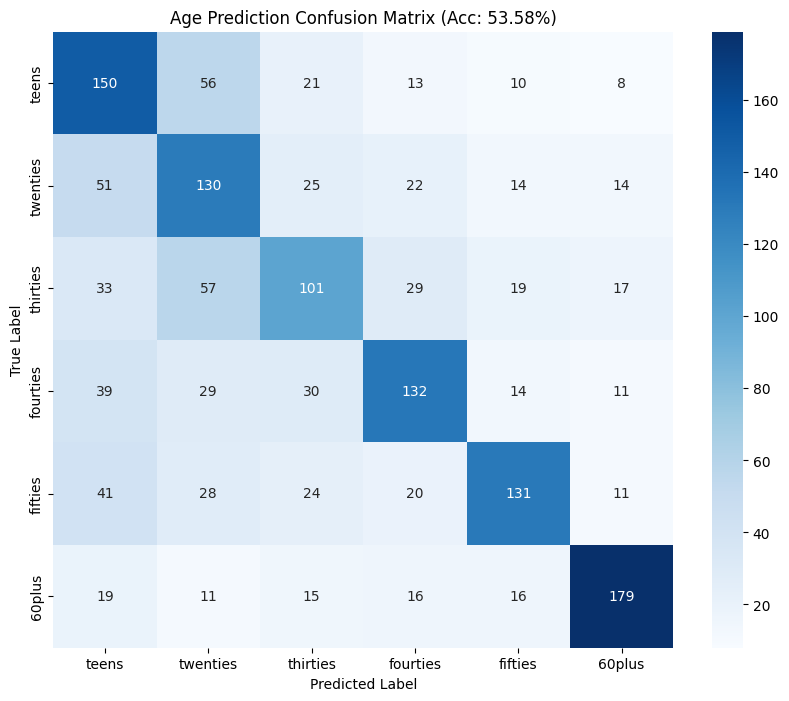

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm

# --- 1. Configuration & Paths ---

# Main Project Folder
PROJECT_PATH = "/content/drive/MyDrive/Voice project/"


FEATURES_PATH = "/content/drive/MyDrive/voice_project/features_melspec_5sec_all"

# Paths to Lists & Stats
TEST_LIST_PATH = "/content/drive/MyDrive/voice_project/test_list.csv"
STATS_PATH = "/content/drive/MyDrive/voice_project/scaling_stats"

# Path to your saved model
MODEL_SAVE_PATH = "/content/drive/MyDrive/voice_project/First_model_building.pth"

# Label Maps
AGE_MAP = {'teens': 0, 'twenties': 1, 'thirties': 2, 'fourties': 3, 'fifties': 4, '60plus': 5}
GENDER_MAP = {'female': 0, 'male': 1}

# GPU Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Configuration Set. Using device: {device}")
print(f"Reading features from: {FEATURES_PATH}")

# 2. Define Dataset Class (NPY Version)
# This version loads the pre-calculated .npy files for speed

class VoiceDatasetNPY(Dataset):
    def __init__(self, csv_file, features_dir, mean, std):
        self.data_list = pd.read_csv(csv_file)
        self.features_dir = features_dir
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        row = self.data_list.iloc[idx]

        # Convert mp3 filename to npy filename
        npy_filename = row['path'].replace(".mp3", ".npy")
        file_path = os.path.join(self.features_dir, npy_filename)

        try:
            # 1. Load the pre-calculated spectrogram
            spectrogram = np.load(file_path)

            # 2. Scale (Normalize)
            # (X - Mean) / Std
            norm_spectrogram = (spectrogram - self.mean) / self.std

            # 3. Convert to Tensor (Add channel dim)
            # Shape becomes [1, 128, 216]
            spec_tensor = torch.tensor(norm_spectrogram, dtype=torch.float32).unsqueeze(0)

            # 4. Get Labels
            age_label = torch.tensor(AGE_MAP[row['age']], dtype=torch.long)
            gender_label = torch.tensor(GENDER_MAP[row['gender']], dtype=torch.long)

            return spec_tensor, age_label, gender_label

        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            # Return dummy data to prevent crash
            return torch.zeros((1, 128, 216)), torch.tensor(0), torch.tensor(0)

# 3. Define Model Architecture


class VoiceCNN(nn.Module):
    def __init__(self, num_age_classes=6, num_gender_classes=2):
        super(VoiceCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()
        self.fc_shared = nn.Linear(64 * 16 * 27, 128)
        self.fc_bn = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)

        self.age_head = nn.Linear(128, num_age_classes)
        self.gender_head = nn.Linear(128, num_gender_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = self.flatten(x)
        x = self.dropout(F.relu(self.fc_bn(self.fc_shared(x))))

        age = self.age_head(x)
        gender = self.gender_head(x)
        return age, gender

# --- 4. Initialize & Run Test ---

# A. Load Statistics
try:
    GLOBAL_MEAN = np.load(os.path.join(STATS_PATH, "global_mean.npy"))
    GLOBAL_STD = np.load(os.path.join(STATS_PATH, "global_std.npy"))
    print(f"Scaling Stats loaded: Mean={GLOBAL_MEAN:.2f}, Std={GLOBAL_STD:.2f}")
except:
    print("Could not load stats file! Defaulting to 0/1 scaling.")
    GLOBAL_MEAN, GLOBAL_STD = 0.0, 1.0

# B. Prepare Data Loader
# Note: num_workers=2 is usually fine for .npy files on Drive,
# but if it hangs, change it to num_workers=0
test_ds = VoiceDatasetNPY(TEST_LIST_PATH, FEATURES_PATH, GLOBAL_MEAN, GLOBAL_STD)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

print(f"Test Set Size: {len(test_ds)} samples")

# C. Load Model Weights
model = VoiceCNN().to(device)

if os.path.exists(MODEL_SAVE_PATH):
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
    print(f"Model weights loaded from: {MODEL_SAVE_PATH}")
else:
    print(f"CRITICAL ERROR: Model file not found at {MODEL_SAVE_PATH}")

# D. Evaluation Loop
model.eval()
all_age_preds = []
all_age_true = []
all_gender_preds = []
all_gender_true = []

print("\nStarting Evaluation on Test Set...")
with torch.no_grad():
    for specs, ages, genders in tqdm(test_loader):
        specs = specs.to(device)

        # Run Model
        age_preds, gender_preds = model(specs)

        # Get Predictions
        _, p_age = torch.max(age_preds, 1)
        _, p_gender = torch.max(gender_preds, 1)

        # Store for metrics
        all_age_preds.extend(p_age.cpu().numpy())
        all_age_true.extend(ages.numpy())
        all_gender_preds.extend(p_gender.cpu().numpy())
        all_gender_true.extend(genders.numpy())

# --- 5. Final Results ---

age_acc = 100 * (np.array(all_age_preds) == np.array(all_age_true)).mean()
gender_acc = 100 * (np.array(all_gender_preds) == np.array(all_gender_true)).mean()

print("\n" + "="*40)
print(f"FINAL TEST RESULTS")
print("="*40)
print(f"Gender Accuracy: {gender_acc:.2f}%")
print(f"Age Accuracy:    {age_acc:.2f}%")
print("="*40)

# Classification Report
print("\n--- Age Classification Report ---")
target_names = list(AGE_MAP.keys())
print(classification_report(all_age_true, all_age_preds, target_names=target_names))

# Confusion Matrix Plot
cm = confusion_matrix(all_age_true, all_age_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'Age Prediction Confusion Matrix (Acc: {age_acc:.2f}%)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()